In [2]:
%pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


In [6]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix)

In [7]:
# Read data
df = pd.read_csv('dataset_phishing.csv')

In [8]:
features = ['shortest_word_path',
 'ratio_intMedia',
 'links_in_tags',
 'nb_hyphens',
 'page_rank',
 'avg_word_path',
 'ratio_extHyperlinks',
 'longest_words_raw',
 'google_index',
 'length_hostname',
 'longest_word_host',
 'domain_registration_length',
 'nb_www',
 'nb_underscore',
 'nb_dots',
 'ratio_extMedia',
 'phish_hints',
 'domain_in_title',
 'web_traffic',
 'safe_anchor',
 'nb_space',
 'shortening_service',
 'ip',
 'domain_age',
 'nb_qm',
 'nb_hyperlinks',
 'nb_slash']

In [9]:
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

le = LabelEncoder()
y = le.fit_transform(df["status"])

# Step 1: Split data into 70% trian and 30% temp (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Step 2: Split the temp set into 50% validation and 50% test (15% each of the original data)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Using Cross-Validation Recall

[0.9402687682385086, 0.8892471019745607, 0.9410147271116397, 0.9208555603055706, 0.9417603762011859, 0.9290673035817179, 0.943752594437526, 0.9313101367384744, 0.9380290329176038, 0.9305632485145876, 0.9385274747061704, 0.9263309851737576, 0.9325539178330018, 0.9238421838503623, 0.9300648067260212, 0.9263300558230021, 0.9308104558155673, 0.9248365891588136, 0.9303123238105859, 0.9235924982807011]
The optimal k is 7 with a cross-validation recall of 0.9438


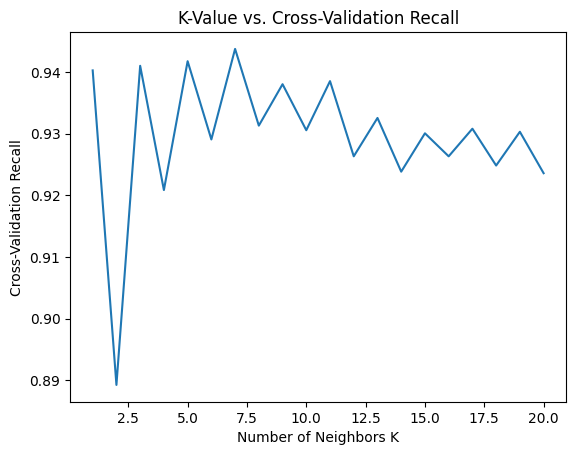

Accuracy: 0.9463

Confusion Matrix:
[[1642   90]
 [  94 1603]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1732
           1       0.95      0.94      0.95      1697

    accuracy                           0.95      3429
   macro avg       0.95      0.95      0.95      3429
weighted avg       0.95      0.95      0.95      3429

Accuracy: 0.9463400408282298
Precision: 0.9468399291199054
Recall: 0.9446081319976429
F1 Score: 0.9457227138643067


In [5]:
# Define range of k values to test
k_values = range(1, 21)

# List to store cross-validation scores
cv_scores = []

# Loop over different k values
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    # Perform 5-fold cross-validation
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='recall')
    # Append mean of cross-validation scores
    cv_scores.append(scores.mean())
print(cv_scores)

# Find the optimal k (k with the highest accuracy)
optimal_k = k_values[np.argmax(cv_scores)]
print(f"The optimal k is {optimal_k} with a cross-validation recall of {max(cv_scores):.4f}")

# Plotting the cross-validation accuracy for each k
plt.plot(k_values, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Cross-Validation Recall')
plt.title('K-Value vs. Cross-Validation Recall')
plt.show()

# Initialize KNN model (you can change n_neighbors for different results)
knn = KNeighborsClassifier(n_neighbors=optimal_k)

# Train the model
knn.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Output results
print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

tn = conf_matrix[0][0]
fn = conf_matrix[1][0]
tp = conf_matrix[1][1]
fp = conf_matrix[0][1]
accuracy = (tp + tn) / (tp + tn + fp + fn)
print(f"Accuracy: {accuracy}")
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Precision: {precision}\nRecall: {recall}\nF1 Score: {f1_score}")

## Trying with GridSearch

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score

# Features and target variable
X = df[features]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode target labels
le = LabelEncoder()
y = le.fit_transform(df["status"])

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Define parameter grid for GridSearchCV
param_grid = {
    'n_neighbors': range(1, 21),           # Test k values from 1 to 20
    'weights': ['uniform', 'distance'],    # Uniform or distance-weighted voting
    'metric': ['euclidean', 'manhattan', 'minkowski'],  # Different distance metrics
    'p': [1, 2]                            # Power parameter for Minkowski (p=1 is Manhattan, p=2 is Euclidean)
}

# Initialize KNN model
knn = KNeighborsClassifier()

# Set up GridSearchCV to test different hyperparameter combinations
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='recall', verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Output the best parameters
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best cross-validation recall: {grid_search.best_score_:.4f}")

# Evaluate the model with the optimal hyperparameters on the test set
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test)

# Test set recall score
test_recall = recall_score(y_test, y_pred)
print(f"Test set recall: {test_recall:.4f}")


# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Output results
print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

tn = conf_matrix[0][0]
fn = conf_matrix[1][0]
tp = conf_matrix[1][1]
fp = conf_matrix[0][1]
accuracy = (tp + tn) / (tp + tn + fp + fn)
print(f"Accuracy: {accuracy}")
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Precision: {precision}\nRecall: {recall}\nF1 Score: {f1_score}")

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best hyperparameters: {'metric': 'manhattan', 'n_neighbors': 6, 'p': 1, 'weights': 'distance'}
Best cross-validation recall: 0.9617
Test set recall: 0.9635
Accuracy: 0.9583

Confusion Matrix:
[[1651   81]
 [  62 1635]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1732
           1       0.95      0.96      0.96      1697

    accuracy                           0.96      3429
   macro avg       0.96      0.96      0.96      3429
weighted avg       0.96      0.96      0.96      3429

Accuracy: 0.958296879556722
Precision: 0.9527972027972028
Recall: 0.9634649381261049
F1 Score: 0.9581013770876062


In [10]:
# Define KNN model and hyperparameter grid
knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': range(1, 21),           # Test k values from 1 to 20
    'weights': ['uniform', 'distance'],    # Uniform or distance-weighted voting
    'metric': ['euclidean', 'manhattan', 'minkowski'],  # Different distance metrics
    'p': [1, 2]                            # Power parameter for Minkowski (p=1 is Manhattan, p=2 is Euclidean)
}

# Perform GridSearchCV with validation set
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='recall', verbose=1)
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_knn = grid_search.best_estimator_

# Evaluate on the validation set
y_val_pred = best_knn.predict(X_val)
y_val_pred_prob = best_knn.predict_proba(X_val)[:, 1]

# Calculate validation metrics
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
val_roc_auc = roc_auc_score(y_val, y_val_pred_prob)
val_conf_matrix = confusion_matrix(y_val, y_val_pred)

# Display validation results
print("\nValidation Results:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"F1 Score: {val_f1:.4f}")
print(f"ROC-AUC Score: {val_roc_auc:.4f}")
print(f"Confusion Matrix:\n{val_conf_matrix}")

# Final evaluation on the test set
y_test_pred = best_knn.predict(X_test)
y_test_pred_prob = best_knn.predict_proba(X_test)[:, 1]

# Calculate test metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

# Display final test results
print("\nFinal Test Results:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"ROC-AUC Score: {test_roc_auc:.4f}")
print(f"Confusion Matrix:\n{test_conf_matrix}")


Fitting 5 folds for each of 240 candidates, totalling 1200 fits

Validation Results:
Accuracy: 0.9533
Precision: 0.9477
Recall: 0.9568
F1 Score: 0.9523
ROC-AUC Score: 0.9872
Confusion Matrix:
[[836  44]
 [ 36 798]]

Final Test Results:
Accuracy: 0.9633
Precision: 0.9577
Recall: 0.9699
F1 Score: 0.9637
ROC-AUC Score: 0.9891
Confusion Matrix:
[[815  37]
 [ 26 837]]
